### 2024.9.6 22:40
现在是写完了联合标签训练的测试，但有问题：第一个是标签不均衡的问题，共有的那几个类几率会增高，显然不对劲。
另一个是MLP的drop_out上，train和val的时候输出的logits差别很大。train的时候是正常的，但val时候所有样本logits同质化。原因好像是val的时候会自动关闭模型中的dropout层（删掉dropout会导致train和val全变成左边的样子......
现在是准备跑一下单个数据集（Faced 9 class）上的Baseline，看看logits同质化的问题是否只是初期现象，会不会随着训练好转。

#### val时batch内logits同质化，以及train时的正常logits，以及对应标签（Faced 56*9）
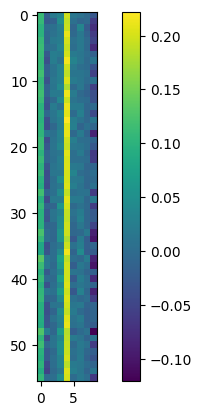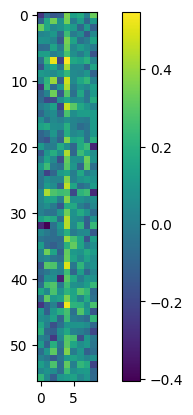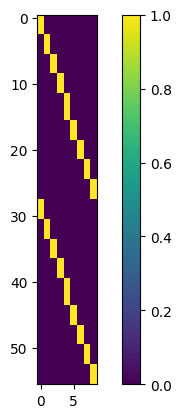
#### 计算的一个batch的de特征实例，看起来还算正常？
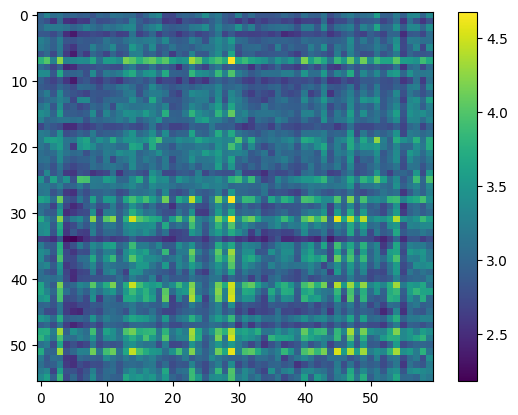
#### 标签不均衡logits
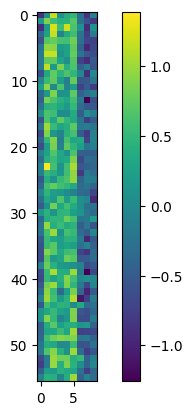

#### 涉事MLP代码

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, dropout=0.2, bn='no'):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # if (bn == 'bn1') or (bn == 'bn2'):
        self.bn1 = nn.BatchNorm1d(hidden_dim, affine=False)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        # if bn == 'bn2':
        self.bn2 = nn.BatchNorm1d(hidden_dim//2, affine=False)
        self.fc3 = nn.Linear(hidden_dim//2, out_dim)
        self.bn = bn
        self.drop = nn.Dropout(p=dropout)
        # self.flag = False
    def forward(self, input):

        out = F.relu(self.fc1(input))

        if (self.bn == 'bn1') or (self.bn == 'bn2'):
            out = self.bn1(out)
        out = self.drop(out)
        out = F.relu(self.fc2(out))

        if self.bn == 'bn2':
            out = self.bn2(out)
        out = self.drop(out)
        out = self.fc3(out)

        return out

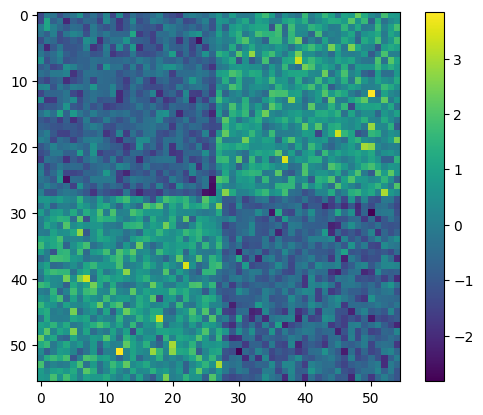